In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from improve_dmdc import Improved_DMDc_new
# Generate random stable A (5x5)
np.random.seed(0)  # For reproducibility
lambdas = np.random.uniform(-0.99, 0.99, 5)
P = np.linalg.qr(np.random.randn(5, 5))[0]
A = P @ np.diag(lambdas) @ np.linalg.inv(P)

# Generate random B (5x2)
B = np.random.randn(5, 2)

# Initial condition
x0 = np.ones(5)

N_t = 100

# Generate random control inputs Γ (2x50)
Gamma = np.random.randn(2, N_t)

# Simulate the system
X_data = np.zeros((5, N_t + 1))
X_data[:, 0] = x0
for k in range(N_t):
    X_data[:, k+1] = A @ X_data[:, k] + B @ Gamma[:, k]

U_control = Gamma  # 2x50 (control inputs at k=0 to k=49)

# Apply Improved DMDc
rank_p, rank_r = 10, 5
N_traint = int(0.8 * N_t)  # 80% of data for training
U_train = U_control[:, :N_traint]  # Control inputs for training
X_train = X_data[:, :N_traint]  # States for training
# Apply Improved DMDc to learn the system dynamics
eigenvalues, modes, recons, bar_A, bar_B, bar_V = Improved_DMDc_new(X_data=X_train, U_control=U_train, rank_p=rank_p, rank_r=rank_r)

# Predict future states using the learned model
# Start from the last state in training data
X_test_init = X_data[:,N_traint].reshape(-1, 1)
z_k = bar_V.T @ X_test_init

prediction_horizon = N_t - N_traint + 1
Y_pred = np.zeros((X_data.shape[0], prediction_horizon))
Y_pred[:, 0] = (bar_V @ z_k).flatten()

z_current = z_k
for i in range(prediction_horizon):
    u_current = U_control[:, N_t - N_future + i].reshape(-1, 1)
    z_next = bar_A @ z_current + bar_B @ u_current
    Y_pred[:, i + 1] = (bar_V @ z_next).flatten()
    z_current = z_next
eigenvalues, modes, recons, bar_A, bar_B, bar_V = Improved_DMDc_new(X_data=X_data, U_control=U_control, rank_p=rank_p, rank_r=rank_r)


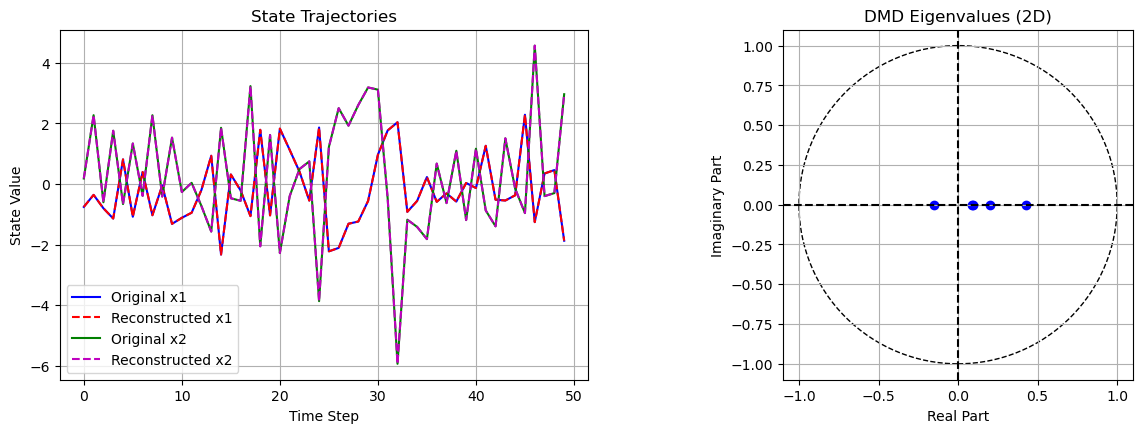

In [9]:
from mpl_toolkits.mplot3d import Axes3D


# Visualization
fig = plt.figure(figsize=(15, 10))

# Plot 1: State trajectories
ax1 = fig.add_subplot(221)
ax1.plot(range(N_t), X_data[0, 1:], 'b-', label='Original x1')
ax1.plot(range(N_t), recons[0, :], 'r--', label='Reconstructed x1')
ax1.plot(range(N_t), X_data[1, 1:], 'g-', label='Original x2')
ax1.plot(range(N_t), recons[1, :], 'm--', label='Reconstructed x2')
ax1.set_title('State Trajectories')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('State Value')
ax1.legend()
ax1.grid(True)

# Plot 2: Eigenvalues in 2D (complex plane)
ax2 = fig.add_subplot(222)
ax2.scatter(eigenvalues.real, eigenvalues.imag, c='b', marker='o')
ax2.axhline(0, color='k', linestyle='--')
ax2.axvline(0, color='k', linestyle='--')
circle = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax2.add_artist(circle)
ax2.set_xlim([-1.1, 1.1])
ax2.set_ylim([-1.1, 1.1])
ax2.set_title('DMD Eigenvalues (2D)')
ax2.set_xlabel('Real Part')
ax2.set_ylabel('Imaginary Part')
ax2.grid(True)
ax2.set_aspect('equal', adjustable='box')

# plt.tight_layout()
# plt.savefig('linear_system_dmdc_analysis.png')
# plt.close()